In [38]:
import numpy as np

### Read Tiff files into npz

In [117]:
def get_image(file_name):
    """Read image from file and returns it as a tensor
    Function from deepcell.utils

    Args:
        file_name: path to image file

    Returns:
        numpy array of image data
    """
    ext = os.path.splitext(file_name.lower())[-1]
    if ext == '.tif' or ext == '.tiff':
        return np.float32(TiffFile(file_name).asarray())
    return np.float32(imread(file_name))

X = get_image('/Users/sunnycui/Downloads/RajLab_OrganoidPilot/stack_001_dapi.tif')
y = get_image('/Users/sunnycui/Downloads/RajLab_OrganoidPilot/stack_001_gt_nuclei.tif')

print(X.shape, y.shape)

output_directory = '/Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz/'
file_name_save = os.path.join(output_directory, 'stack_001_nuclei.npz')

X=np.vstack((X[:, :160, :160],X[:, 140:, 140:])) #, X[:, 250:, 248:]))
y=np.vstack((y[:, :160, :160],y[:, 140:, 140:])) #, y[:, 250:, 248:]))

np.savez(file_name_save, X=X, y=y)

print(X.shape, y.shape)

(27, 300, 300) (27, 300, 300)
(54, 160, 160) (54, 160, 160)


### Test plot images

Text(0.5, 1.0, 'nuclei')

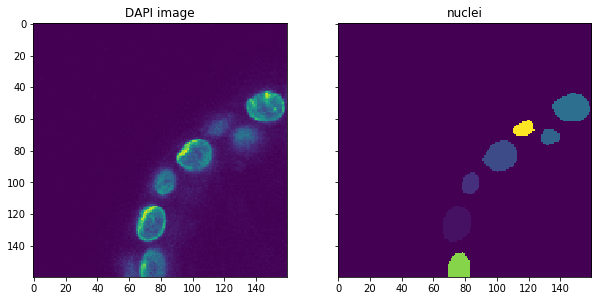

In [118]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X[10])
ax[0].set_title('DAPI image')

ax[1].imshow(y[10])
ax[1].set_title('nuclei')

# Crop and combine into a single npz

In [119]:
# Define a normalizaiton function for the raw images that can be run before padding
def image_norm(original_image):
    # NNs prefer input data that is 0 mean and unit variance
    normed_image = (original_image - np.mean(original_image)) / np.std(original_image)
    return normed_image

filename = 'combined_data.npz'

DATA_DIR = '/Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz'

data_path = os.path.join(DATA_DIR, filename)


if True: #not os.path.isfile(data_path):
    # Define all the npz to load
    npz_files = [os.path.join(DATA_DIR, 'stack_001_nuclei.npz'), 
                  os.path.join(DATA_DIR, 'stack_023_nuclei.npz'), 
                  os.path.join(DATA_DIR, 'stack_041_nuclei.npz')]

    # Each TRKS file may have differrent dimensions but the model expects uniform dimensions
    print("determine min dimensions and crop as neccesary")
    min_frames = np.inf
    min_y = np.inf
    min_x = np.inf
    for npz_file in npz_files:
        npz = np.load(npz_file)
        # Store dimensions of raw and tracked to check new data against to pad if neccesary
        if npz['X'].shape[0] < min_frames:
            min_frames = npz['X'].shape[0]
        if npz['X'].shape[1] < min_y:
            min_y = npz['X'].shape[1]
        if npz['X'].shape[2] < min_x:
            min_x = npz['X'].shape[2]
            
    print("min_frames: ", min_frames)
    print("min_y: ", min_y)
    print("min_x: ", min_x)
            
    print("\n Load each npz file, normalize and crop as neccesary")
    X = []
    y = []        
    k = 0
    
    for npz_file in npz_files:
        print("processing: ", npz_file)
        npz = np.load(npz_file)
        X_temp = np.zeros((npz['X'].shape[0], min_y, min_x))
        y_temp = np.zeros((npz['y'].shape[0], min_y, min_x))
        for i, (raw, tracked) in enumerate(zip(npz['X'], npz['y'])):
            k += 1

            # Normalize the raw images
            raw = image_norm(raw) 

            # Crop if neccesary - This assumes that raw and tracked have the same shape
            if raw.shape[0] > min_y:
                raw = raw[:min_y, :]
                tracked = tracked[:min_y, :]
        
            if raw.shape[1] > min_x:
                raw = raw[:, :min_x]
                tracked = tracked[:, :min_x]
                
            X.append(raw)
            y.append(tracked)

    # Save the combined datasets into one npz file
    X = np.array(X)
    y = np.array(y)
    
    output_directory = '/Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz/'
    file_name_save = os.path.join(output_directory, 'combined_nuclei.npz')
    
    print(X.shape, y.shape)
    np.savez(file_name_save, X=X, y=y)

determine min dimensions and crop as neccesary
min_frames:  24
min_y:  160
min_x:  160

 Load each npz file, normalize and crop as neccesary
processing:  /Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz/stack_001_nuclei.npz
processing:  /Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz/stack_023_nuclei.npz
processing:  /Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz/stack_041_nuclei.npz
(222, 160, 160) (222, 160, 160)


### Add channels

In [148]:
DATA_DIR = '/Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz'
data_path = os.path.join(DATA_DIR, 'combined_nuclei.npz')

combined_npz = np.load(data_path)

X_full, y_full = combined_npz['X'], combined_npz['y']

channel_names = [""]
annotation_name = [""]

X_shape = tuple(list(X_full.shape) + [len(channel_names)])
y_shape = tuple(list(y_full.shape) + [len(annotation_name)])

print("X_shape: ", X_shape)

X = np.zeros(X_shape, dtype='int32')
y = np.zeros(y_shape, dtype='int32')


for c, channel in enumerate(channel_names):
    X[:,:,:,c] = X_full

for l, annotation in enumerate(annotation_name):
    y[:,:,:,l] = y_full
    
output_directory = '/Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz/'
file_name_save = os.path.join(output_directory, 'combined_is_nuclei.npz')

print(X.shape, y.shape)
np.savez(file_name_save, X=X, y=y)

X_shape:  (222, 160, 160, 1)
(222, 160, 160, 1) (222, 160, 160, 1)


### Test plot combined data

In [149]:
DATA_DIR = '/Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz'
data_path = os.path.join(DATA_DIR, 'combined_is_nuclei.npz')

combined_npz = np.load(data_path)

X_data, y_data = combined_npz['X'], combined_npz['y']
print(X_data.shape, y_data.shape)

(222, 160, 160, 1) (222, 160, 160, 1)


1


Text(0.5, 1.0, 'nuclei')

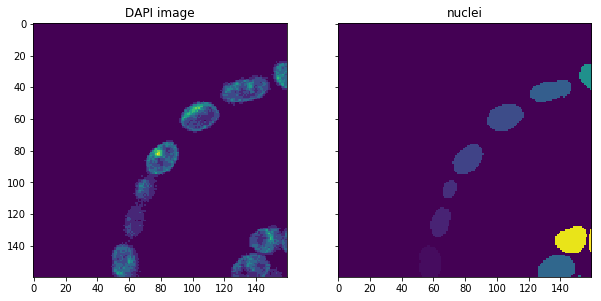

In [150]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

print(X_data.shape[3])
ax[0].imshow(X_data[20, :, :, 0])
ax[0].set_title('DAPI image')

ax[1].imshow(y_data[20, :, :, 0])
ax[1].set_title('nuclei')

In [131]:
print(np.unique(y[20]))

[ 0.  1.  3.  4.  6.  7.  9. 10. 12. 15. 29. 30.]
